In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import random
from datetime import datetime
from faker import Faker

**Steps:**
1. [x] Decide the variables 
2. [x] Fake data for one student 
3. [x] Fake data for one class
4. [ ] Fake data for multiple classes 
5. [x] Fake data for multiple terms 

---
### Decide the variables:

In [2]:
# Basic_Info:
    # id 
    # f_name
    # l_name
    # gender
    # race
    # birth_dt
    # address
    # email
    
# Academic_Performance:
    # Grades of quizzes, exams, home assignments
    # Attendance
    # Number of on-time, late, and missed assignments
    # Number of accesses to LMS
    # Average time spent on LMS
    # Messages on LMS (for example, number of questions and responses on the discussion forum)

---
### Fake data for one student:

In [3]:
import bisect

def bi_search(arr, x): # binary search
    i = bisect.bisect(arr, x)-1
    if i != len(arr) and arr[i] == x:
        return i
    return False

bi_search(np.asarray([1, 2, 5, 8]), 6)

False

In [4]:
def ewma_predict(series, span=3, jump=1): # jump is the diff in time bw the date of prediction & the last observation
    if len(series) == 1: #if the series has only 1 element
        return series.iloc[0]
    
    s_clone = series # shallow copy for efficiency
    
    if s_clone.iloc[-1] == 0:   # if the most recent grade is from a missed assigment, i.e. grade = 0
        s_clone = series.copy() # deep copy
        s_clone.iloc[-1] = s_clone.ewm(span=span).mean().iloc[-1]
        # set that grade equal to the ewma
        # this is to alleviate the disastrous effect of a grade of 0 
    
    inter = s_clone.ewm(span=span).mean().iloc[-1]
    
    differences = s_clone.diff()
    slope = differences.ewm(span=span).mean().iloc[-1]
    
    return inter + slope*jump

In [5]:
def miss_chance(index, cum_mean_grade, gra_slope=0.5):
    if index < 2: # first few assignments
        return random.betavariate(1.1, 15)*100 # very unlikely to miss on the first few assignments
    
    if cum_mean_grade >= 60: # D- or higher
        missed = random.betavariate(1.1, 10)*100 - gra_slope*np.power(cum_mean_grade, 0.73)
    else:
        missed = random.betavariate(1.5, 8)*100 - (gra_slope-0.1)*np.power(cum_mean_grade, 0.73)
        # more likely to miss assignment if mean grade is < 60
    
    return missed

In [6]:
def fake_student_grades(grade1_mu, grade1_std, n_quiz, n_home, last_home_idx, n_exams, exam1_idx):
    total_n_grades = n_home + n_quiz + n_exams 
    # total number of grades: home assignments, quizzes, exams
    # the indexes of range(0, total_n_grades) are the "positions" of each grade
    
    home_pos = np.round(np.linspace(start=0, stop=last_home_idx, num=n_home)).astype(int)
    # the "positions" of the home assignments
    # suppose that the 1st grade is from a home assignments: start=0
    
    exam_pos = np.round(np.linspace(start=exam1_idx, stop=total_n_grades-1, num=n_exams)).astype(int)
    # the "positions" of the exams
    # suppose that the final grade is from an exam: stop=total_n_grades-1
    
    for i, pos in enumerate(exam_pos):
        if bi_search(home_pos, pos): # check if the positions of home assignments and exams overlap 
            home_pos[i] -= 1         # if so, subtract the position of the home assignment by 1
    
    home_exam_pos = np.concatenate((home_pos, exam_pos))
    
    quiz_pos = [p for p in range(total_n_grades) if p not in home_exam_pos]
    # the rest is positions of the quizzes
    
    grade1 = int(round(random.gauss(grade1_mu, grade1_std)))
    grade1 = grade1 if grade1 <= 100 else 100 # can't be > 100
    grade1 = grade1 if grade1 >= 0 else 0 # can't be < 0
    grade_series = pd.Series([grade1])
    
    var_std = random.uniform(1, 3)
    # print("Variation std:", var_std)
    
    for g in range(1, total_n_grades):
        span = 3  
        home_idx = bi_search(home_pos, g)
        if home_idx: # if it's a home assignment:
            cum_mean_grade = grade_series.mean()
            
            if miss_chance(home_idx, cum_mean_grade)>40:
                grade_series = grade_series.append(pd.Series(0)) # missed if miss_chance > 40%
                continue

            variation = random.gauss(1, var_std) # grades of home assignments tend to be higher: mu=1
        
        elif bi_search(quiz_pos, g): # quiz
            variation = random.gauss(0, var_std)
        
        else: # exam
            variation = random.gauss(-1, var_std) # grades of exams tend to be lower: mu=-1
            span = 5 # exams tend to cover a larger range of content
        
        next_grade = ewma_predict(grade_series, span) + variation
        next_grade = next_grade if next_grade <= 100 else 100 # can't be > 100
        next_grade = next_grade if next_grade >= 0 else 0 # can't be < 0
        next_grade = pd.Series(next_grade).round()
        
        grade_series = grade_series.append(next_grade)
        #print(grade_series)
    
    home_series = grade_series.iloc[home_pos]
    exam_series = grade_series.iloc[exam_pos]
    quiz_series = grade_series.iloc[quiz_pos]
    
    # reset index:
    for s in [home_series, exam_series, quiz_series]:
        s.reset_index(inplace=True, drop=True)
        
    return grade_series, home_series, exam_series, quiz_series

args = { 
    'grade1_mu':78, 
    'grade1_std': 5, 
    'n_quiz': 2,  
    'n_home': 3, 
    'last_home_idx': 4, # starts at 0
    'n_exams': 0, 
    'exam1_idx': 0      # if there's no exam, put 0
}

fake_student_grades(**args)

(0    85.0
 0    82.0
 0    82.0
 0    82.0
 0    83.0
 dtype: float64,
 0    85.0
 1    82.0
 2    83.0
 dtype: float64,
 Series([], dtype: float64),
 0    82.0
 1    82.0
 dtype: float64)

In [7]:
def fake_student_submission(mean_grade, home_grade_series, ontime_slope=0.3, **kwargs):
    missed = home_grade_series.loc[home_grade_series==0].count()
    missed = missed*100/len(home_grade_series)
    missed = float('{:.2f}'.format(missed)) # round to 2 decimal places
    
    ontime_and_late = 100 - missed 
    
    ontime_slope = ontime_slope if ontime_slope >= 0.3 else 0.3
    # 0.3 is the default slope bw grade and on_time submissions
    # some classes may have a stricter policy regarding deadlines
    
    if mean_grade >= 70: # C- or higher
        on_time = random.betavariate(13, 2)*100 + ontime_slope*np.power(mean_grade, 0.73)
    else:
        on_time = random.betavariate(60, 25)*100 + (ontime_slope-0.1)*np.power(mean_grade, 0.73)
        # more likely to have late submissions if mean grade is < 70
        # the relation bw grade and on-submission is weaker: gra_slode-0.1
    
    on_time = on_time if on_time<100 else 100 # cannot be > 100
    on_time = (on_time*ontime_and_late)/100
    on_time = float('{:.2f}'.format(on_time))
    
    late = ontime_and_late - on_time
    late = float('{:.2f}'.format(late))
    
    return on_time, late, missed

fake_student_submission(70, pd.Series([65, 60, 10, 55, 67]))

(100.0, 0.0, 0.0)

In [8]:
def fake_student_attendance(mean_grade, att_min_gra_slope=0.4, att_max_gra_slope=0.6, 
                            hi_beta_para=(13, 2), lo_beta_para=(30, 25), **kwargs):
    # slope is from a uniform distribution
    slope = random.uniform(att_min_gra_slope, att_max_gra_slope)
    # print('slope:', slope)

    # intercept is from a beta distribution
    if mean_grade >= 70: # C- or higher
        inter = random.betavariate(hi_beta_para[0], hi_beta_para[1]) * 100
        attendance = np.power(mean_grade, 0.7)*slope + inter
    else:
        inter = random.betavariate(lo_beta_para[0], lo_beta_para[1]) * 100
        attendance = np.power(mean_grade, 0.6)*slope + inter
    # print('Inter:', inter)
     
    attendance = attendance if attendance<100 else 100 # cannot be > 100
    attendance = float('{:.2f}'.format(attendance))    # round to 2 decimal places
    
    return attendance

print(fake_student_attendance(90))
print(fake_student_attendance(60))

94.6
57.76


In [9]:
def fake_student_LMS_accesses(mean_grade, acc_gra_slope_mu=1, acc_gra_slope_std=0.1, 
                              acc_inter_mu=3, acc_inter_std=0.1, **kwargs): 
    # weekly LMS accesses
    gra_slope = random.gauss(acc_gra_slope_mu, acc_gra_slope_std)
    inter = random.gauss(acc_inter_mu, acc_inter_std) # account for other random factors than grade
    
    # the default acc_inter_mu = 3
    # given that acc_gra_slope_mu = 1
    # a student with a grade of 90 is expected to have 6 accesses/week
    # to adjust this expectation, change the acc_inter_mu
    
    weekly_accesses = gra_slope*(mean_grade/10) - inter
    weekly_accesses = weekly_accesses if weekly_accesses > 0 else 0.1
    # if the returned result is =< 0, that means we get a very small value
    weekly_accesses = float('{:.2f}'.format(weekly_accesses))
    
    return weekly_accesses

print(fake_student_LMS_accesses(90))
print(fake_student_LMS_accesses(60))
        
# this model is strong!
# given that the slope can get as low as 0.6:
# 6*0.6 = 3.6 - 3 = 0.6 > 0.1

4.6
3.1


In [10]:
def fake_student_LMS_time(mean_grade, weekly_accesses, tim_gra_slope_mu=1, norm_tim_gra_slope_std=0.1, 
                          tim_inter_mu=2, tim_inter_std=0.1, tim_acc_slope_mu=0.3, tim_acc_slope_std=0.01, **kwargs):
    
    # average time spent per session in minutes
        
    # the relation to grade is not clear
    # a high grade may indicate that a student is intelligent & understands things quickly
    # or she's diligent and hard-working
    
    if mean_grade >= 83: # B or higher
        gra_slope = random.gauss(tim_gra_slope_mu, norm_tim_gra_slope_std+0.05)
        # the slope varies more for students with high grades
    else:
        gra_slope = random.gauss(tim_gra_slope_mu, norm_tim_gra_slope_std)
        
    acc_slope = random.gauss(tim_acc_slope_mu, tim_acc_slope_std) # higher freq of accesses often means less session time
    inter = random.gauss(tim_inter_mu, tim_inter_std) # account for other random factors than grade
    
    session_time = gra_slope*(mean_grade/10) - acc_slope*np.power(1.2, weekly_accesses) - inter
    
    session_time = session_time if session_time > 0 else 0.1 
    # if the returned result is =< 0, that means we get a very small value
    session_time = float('{:.2f}'.format(session_time))
    
    # adjust the time_inter_mu to raise/lower the (expected) session time
    
    return session_time

fake_student_LMS_time(90, 6)

6.56

In [11]:
def fake_student_LMS_mess(mean_grade, n_mess_mu, mess_gra_slope=0.13, **kwargs): 
    # n_mess_mu is the mean num of messages of the whole class
    if mean_grade >= 70: # C- or higher
        lambd = 1.0/(n_mess_mu+0.5)
        # the mean number of messages is higher for students with score >= 70
    else:
        n_mess_mu = n_mess_mu-2
        n_mess_mu = n_mess_mu if n_mess_mu > 0 else 0.1
        lambd = 1.0/(n_mess_mu)
        # the mean number of messages is lower for students with score < 70
        mess_gra_slope = mess_gra_slope - 0.03
        # the relation bw grade and number of messages is also weaker
    
    inter = random.expovariate(lambd) # intercept is from an exponential dist
    
    mess_num = mess_gra_slope*(mean_grade/10) + (inter - 7*mess_gra_slope)
    mess_num = int(round(mess_num))
    mess_num = mess_num if mess_num > 0 else 0
    
    return mess_num

print(fake_student_LMS_mess(90, 3))
print(fake_student_LMS_mess(70, 3))
print(fake_student_LMS_mess(60, 3))

15
1
0


(array([2., 5., 1., 4., 5., 5., 5., 1., 1., 1.]),
 array([56. , 60.2, 64.4, 68.6, 72.8, 77. , 81.2, 85.4, 89.6, 93.8, 98. ]),
 <a list of 10 Patch objects>)

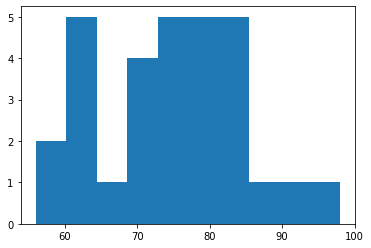

In [12]:
class_size = 30
quiz1_grades = [] 

for i in range(class_size):
    quiz1_grades.append(int(round(random.gauss(mu=75, sigma=10))))
    
plt.hist(quiz1_grades)

(array([2., 4., 2., 4., 3., 5., 5., 1., 3., 1.]),
 array([1.97 , 2.479, 2.988, 3.497, 4.006, 4.515, 5.024, 5.533, 6.042,
        6.551, 7.06 ]),
 <a list of 10 Patch objects>)

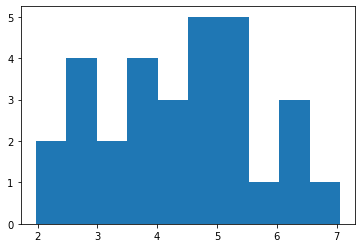

In [13]:
accesses = [fake_student_LMS_accesses(g) for g in quiz1_grades]
plt.hist(accesses)

(array([17.,  0.,  2.,  5.,  1.,  0.,  2.,  0.,  1.,  2.]),
 array([ 0. ,  1.3,  2.6,  3.9,  5.2,  6.5,  7.8,  9.1, 10.4, 11.7, 13. ]),
 <a list of 10 Patch objects>)

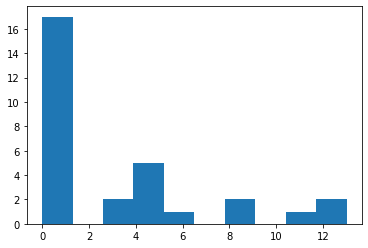

In [14]:
mess = [fake_student_LMS_mess(g, 3) for g in quiz1_grades]
plt.hist(mess)

---
### Fake data for one class:

In [15]:
def fake_class_basic_info(class_size, birth_dt_start, birth_dt_end):
    columns = ['id', 'f_name', 'l_name', 'gender', 'race', 'birth_dt', 'address', 'email']
    info_df = pd.DataFrame(columns=columns)
    
    possible_races = ['White', 'Black', 'Native', 'Asian', 'Pacific Islander', 'Mixed']
    race_prob = [0.763, 0.134, 0.013, 0.059, 0.002, 0.029]
    
    # Faker.seed(1234) # for producing the same results 
    fake = Faker()
    
    for s in range(class_size):
        student = {
            'id': fake.ssn(),
            'l_name': fake.last_name(),
            'gender': random.choice(['M', 'F']),
            'race': np.random.choice(possible_races, replace=True, p=race_prob),
            'birth_dt': fake.date_between_dates(birth_dt_start, birth_dt_end),
            'address': fake.address(),
            'email': fake.free_email()
        }    
        student['f_name'] = fake.first_name_male() if student['gender']=='M' else fake.first_name_female()
        
        info_df = info_df.append(student, ignore_index=True)
    
    return info_df

class20_basic_info = fake_class_basic_info(30, datetime(1997, 1, 1), datetime(2001, 12, 31))
class20_basic_info

,id,f_name,l_name,gender,race,birth_dt,address,email
0,236-92-3898,Sara,Jones,F,White,2000-06-04,"7640 Courtney Station Apt. 917\nThomasside, NJ...",michaelbarrett@hotmail.com
1,335-02-1095,Robert,Riley,M,White,1997-09-27,"8252 Bell Radial Suite 382\nPort Barbara, ME 6...",jon56@gmail.com
2,152-29-0734,Kylie,Robinson,F,White,2000-07-16,"503 Burton Centers Suite 366\nWest Tracyshire,...",daniellepowell@gmail.com
3,123-74-0256,Jennifer,Le,F,White,1999-02-15,"05939 Rivera Drive\nPort Brandon, CA 19872",xlee@gmail.com
4,031-63-6642,Kristy,Mason,F,Asian,2000-01-25,"14383 Dwayne Stravenue\nHeatherside, OH 70307",jacqueline71@gmail.com
5,892-20-4186,Nicole,Rivera,F,White,2000-11-14,"3630 Thompson Village\nLake Samuel, MS 67272",walkerjohn@yahoo.com
6,084-75-8674,Brett,Williams,M,White,2001-01-03,"360 Brown Lane Apt. 888\nJoneschester, LA 51829",sandovalmelissa@hotmail.com
7,132-68-7315,Casey,Willis,F,White,2000-04-19,"49013 Flores Land\nWest Robertstad, WI 25317",amandaduran@hotmail.com
8,716-88-9590,Daisy,Barrett,F,White,2000-07-24,"65678 Henry Common\nChristianport, FL 79108",sarahwaller@hotmail.com
9,805-22-6424,Mary,Blanchard,F,White,2000-06-02,"733 Ronald Mission Apt. 773\nRichardfurt, SD 9...",brandonjones@gmail.com


In [16]:
def fake_class_performance(class_size, n_mess_mu, grade1_mu, grade1_std, n_total_quiz, n_avail_quiz, 
                           n_total_home, n_avail_home, latest_home_idx, 
                           n_total_exams, n_avail_exams, exam1_idx, **paras):
    
    home_cols = ['home{}'.format(i+1) for i in range(n_total_home)]
    quiz_cols = ['quiz{}'.format(i+1) for i in range(n_total_quiz)]
    exam_cols = ['exam{}'.format(i+1) for i in range(n_total_exams)]
    
    columns = ['ontime', 'late', 'missed', 'attendance', 'LMS_accesses', 'LMS_time', 'LMS_mess']
    columns = home_cols + quiz_cols + exam_cols + columns
        
    performance_df = pd.DataFrame(columns=columns)
    
    for st in range(class_size):
        st_all_gr, st_ho_gr, st_exam_gr, st_quiz_gr = fake_student_grades(grade1_mu, grade1_std, n_avail_quiz, n_avail_home, 
                                                                          latest_home_idx, n_avail_exams, exam1_idx)
                
        ho_dict = {'home{}'.format(i+1): hg for i, hg in st_ho_gr.items()}
        quiz_dict = {'quiz{}'.format(i+1): tg for i, tg in st_quiz_gr.items()}
        exam_dict = {'exam{}'.format(i+1): eg for i, eg in st_exam_gr.items()}
        
        mean_gr = st_all_gr.mean()
        
        st_ontime, st_late, st_missed = fake_student_submission(mean_gr, st_ho_gr, **paras)
        st_attendance = fake_student_attendance(mean_gr, **paras)
        st_LMS_accesses = fake_student_LMS_accesses(mean_gr, **paras)
        st_LMS_time = fake_student_LMS_time(mean_gr, st_LMS_accesses, **paras)
        st_LMS_mess = fake_student_LMS_mess(mean_gr, n_mess_mu, **paras)
        
        student = {
            'ontime': st_ontime,
            'late': st_late,
            'missed': st_missed,
            'attendance': st_attendance,
            'LMS_accesses': st_LMS_accesses,
            'LMS_time': st_LMS_time,
            'LMS_mess': st_LMS_mess
        }
        
        student = {**student, **ho_dict, **quiz_dict, **exam_dict}
        
        performance_df = performance_df.append(student, ignore_index=True)
    
    return performance_df
        

args = {
    'class_size': 30, 
    'n_mess_mu': 2, 
    'grade1_mu':85, 
    'grade1_std': 5, 
    'n_total_quiz': 5, 
    'n_avail_quiz': 2, 
    'n_total_home': 5, 
    'n_avail_home': 3, 
    'latest_home_idx': 4, # idx starts at 0  
    'n_total_exams': 2, 
    'n_avail_exams': 1, 
    'exam1_idx': 3,       # idx starts at 0
}

class20_performance = fake_class_performance(**args)
class20_performance

,home1,home2,home3,home4,home5,quiz1,quiz2,quiz3,quiz4,quiz5,exam1,exam2,ontime,late,missed,attendance,LMS_accesses,LMS_time,LMS_mess
0,84.0,82.0,84.0,NaN,NaN,83.0,83.0,NaN,NaN,NaN,80.0,NaN,96.72,3.28,0.0,100.00,5.10,6.04,1.0
1,87.0,86.0,86.0,NaN,NaN,87.0,85.0,NaN,NaN,NaN,86.0,NaN,100.00,0.00,0.0,92.84,6.96,5.47,3.0
2,86.0,89.0,84.0,NaN,NaN,87.0,87.0,NaN,NaN,NaN,79.0,NaN,99.13,0.87,0.0,95.67,3.95,7.33,1.0
3,84.0,81.0,80.0,NaN,NaN,81.0,79.0,NaN,NaN,NaN,79.0,NaN,83.97,16.03,0.0,100.00,4.85,5.39,1.0
4,81.0,81.0,83.0,NaN,NaN,82.0,79.0,NaN,NaN,NaN,84.0,NaN,90.31,9.69,0.0,84.80,4.63,5.85,6.0
5,83.0,77.0,77.0,NaN,NaN,80.0,76.0,NaN,NaN,NaN,78.0,NaN,83.42,16.58,0.0,98.92,4.35,4.82,2.0
6,93.0,97.0,100.0,NaN,NaN,93.0,100.0,NaN,NaN,NaN,97.0,NaN,88.28,11.72,0.0,99.32,5.83,5.03,6.0
7,86.0,83.0,85.0,NaN,NaN,84.0,85.0,NaN,NaN,NaN,83.0,NaN,84.26,15.74,0.0,99.40,6.51,5.84,1.0
8,90.0,90.0,91.0,NaN,NaN,89.0,89.0,NaN,NaN,NaN,90.0,NaN,95.66,4.34,0.0,100.00,5.35,5.61,1.0
9,74.0,61.0,57.0,NaN,NaN,67.0,57.0,NaN,NaN,NaN,56.0,NaN,77.56,22.44,0.0,58.59,3.21,3.40,0.0


In [17]:
def get_final_grade(performance_df, assessment_idxes, weight_series):
    performance_df['final_grade'] = (performance_df.iloc[:, assessment_idxes]
                                     *np.asarray(weight_series)).sum(axis=1, skipna=False)
    # round to 2 dec places:
    performance_df['final_grade'] = performance_df.final_grade.apply(lambda x: float('{:.2f}'.format(x)))
    
    weight_df = pd.DataFrame({'assessment': performance_df.iloc[:, assessment_idxes].columns, 
                              'weight': weight_series})
    
    return weight_df

In [18]:
assessment_idx_list = [i for i in range(12)] + [15] # idx 15 is attendance
weights = [0.04 for i in range(5)] + [0.06 for i in range(5)] + [0.2 for i in range(2)] + [0.1]
weight_df = get_final_grade(class20_performance, assessment_idx_list, weights)
weight_df

,assessment,weight
0,home1,0.04
1,home2,0.04
2,home3,0.04
3,home4,0.04
4,home5,0.04
5,quiz1,0.06
6,quiz2,0.06
7,quiz3,0.06
8,quiz4,0.06
9,quiz5,0.06


In [19]:
# join on index to combine the two df
# assume there's no relationship bw basic info & academic performance

class20_df = class20_basic_info.join(class20_performance)
class20_df['course_code'] = 'CS_320'
class20_df['term_code'] = 'SP_2020' 
class20_df

,id,f_name,l_name,gender,race,birth_dt,address,email,home1,home2,...,ontime,late,missed,attendance,LMS_accesses,LMS_time,LMS_mess,final_grade,course_code,term_code
0,236-92-3898,Sara,Jones,F,White,2000-06-04,"7640 Courtney Station Apt. 917\nThomasside, NJ...",michaelbarrett@hotmail.com,84.0,82.0,...,96.72,3.28,0.0,100.00,5.10,6.04,1.0,NaN,CS_320,SP_2020
1,335-02-1095,Robert,Riley,M,White,1997-09-27,"8252 Bell Radial Suite 382\nPort Barbara, ME 6...",jon56@gmail.com,87.0,86.0,...,100.00,0.00,0.0,92.84,6.96,5.47,3.0,NaN,CS_320,SP_2020
2,152-29-0734,Kylie,Robinson,F,White,2000-07-16,"503 Burton Centers Suite 366\nWest Tracyshire,...",daniellepowell@gmail.com,86.0,89.0,...,99.13,0.87,0.0,95.67,3.95,7.33,1.0,NaN,CS_320,SP_2020
3,123-74-0256,Jennifer,Le,F,White,1999-02-15,"05939 Rivera Drive\nPort Brandon, CA 19872",xlee@gmail.com,84.0,81.0,...,83.97,16.03,0.0,100.00,4.85,5.39,1.0,NaN,CS_320,SP_2020
4,031-63-6642,Kristy,Mason,F,Asian,2000-01-25,"14383 Dwayne Stravenue\nHeatherside, OH 70307",jacqueline71@gmail.com,81.0,81.0,...,90.31,9.69,0.0,84.80,4.63,5.85,6.0,NaN,CS_320,SP_2020
5,892-20-4186,Nicole,Rivera,F,White,2000-11-14,"3630 Thompson Village\nLake Samuel, MS 67272",walkerjohn@yahoo.com,83.0,77.0,...,83.42,16.58,0.0,98.92,4.35,4.82,2.0,NaN,CS_320,SP_2020
6,084-75-8674,Brett,Williams,M,White,2001-01-03,"360 Brown Lane Apt. 888\nJoneschester, LA 51829",sandovalmelissa@hotmail.com,93.0,97.0,...,88.28,11.72,0.0,99.32,5.83,5.03,6.0,NaN,CS_320,SP_2020
7,132-68-7315,Casey,Willis,F,White,2000-04-19,"49013 Flores Land\nWest Robertstad, WI 25317",amandaduran@hotmail.com,86.0,83.0,...,84.26,15.74,0.0,99.40,6.51,5.84,1.0,NaN,CS_320,SP_2020
8,716-88-9590,Daisy,Barrett,F,White,2000-07-24,"65678 Henry Common\nChristianport, FL 79108",sarahwaller@hotmail.com,90.0,90.0,...,95.66,4.34,0.0,100.00,5.35,5.61,1.0,NaN,CS_320,SP_2020
9,805-22-6424,Mary,Blanchard,F,White,2000-06-02,"733 Ronald Mission Apt. 773\nRichardfurt, SD 9...",brandonjones@gmail.com,74.0,61.0,...,77.56,22.44,0.0,58.59,3.21,3.40,0.0,NaN,CS_320,SP_2020


In [20]:
# Fake data for another term:
class19_basic_info = fake_class_basic_info(28, datetime(1996, 1, 1), datetime(2000, 12, 31))

args = {
    'class_size': 28, 
    'n_mess_mu': 3, 
    'grade1_mu': 84, 
    'grade1_std': 3, 
    'n_total_quiz': 5, 
    'n_avail_quiz': 5, 
    'n_total_home': 5, 
    'n_avail_home': 5, 
    'latest_home_idx': 10, # idx starts at 0  
    'n_total_exams': 2, 
    'n_avail_exams': 2, 
    'exam1_idx': 3,       # idx starts at 0
     # **paras:
    'acc_inter_mu': 2.5,
}

class19_performance = fake_class_performance(**args)
get_final_grade(class19_performance, assessment_idx_list, weights)
class19_df = class19_basic_info.join(class19_performance)
class19_df['course_code'] = 'CS_320'
class19_df['term_code'] = 'SP_2019'

class19_df

,id,f_name,l_name,gender,race,birth_dt,address,email,home1,home2,...,ontime,late,missed,attendance,LMS_accesses,LMS_time,LMS_mess,final_grade,course_code,term_code
0,737-70-8841,Kristi,Franklin,F,White,2000-12-19,USNS White\nFPO AP 24868,kbrown@hotmail.com,84.0,82.0,...,96.20,3.80,0.0,96.68,5.50,5.14,13.0,82.35,CS_320,SP_2019
1,504-41-3846,Jessica,Hart,F,White,1996-01-20,"06978 Holly Lakes Apt. 959\nLake Craigburgh, T...",antonioking@gmail.com,84.0,81.0,...,87.56,12.44,0.0,100.00,4.74,5.86,3.0,83.60,CS_320,SP_2019
2,579-26-9434,Kevin,Martin,M,White,1998-07-03,"8911 Mccoy Heights\nJamesburgh, WV 40309",crystalbishop@hotmail.com,85.0,88.0,...,73.80,26.20,0.0,100.00,5.02,2.84,1.0,86.38,CS_320,SP_2019
3,488-67-5764,Mary,Jenkins,F,White,1998-02-27,"9941 Melton Avenue Suite 302\nRoyland, AK 90326",xbowen@yahoo.com,85.0,87.0,...,100.00,0.00,0.0,100.00,6.75,4.08,0.0,87.08,CS_320,SP_2019
4,641-30-6368,Evelyn,Young,F,Black,1998-12-04,USS Jefferson\nFPO AA 04585,wmolina@yahoo.com,84.0,85.0,...,94.97,5.03,0.0,98.92,7.10,5.67,21.0,87.05,CS_320,SP_2019
5,581-86-9790,Angela,Hardin,F,White,1996-04-16,"515 Laurie Trail Suite 173\nWilliamburgh, SC 4...",laura29@yahoo.com,78.0,78.0,...,88.36,11.64,0.0,100.00,4.71,6.09,9.0,81.00,CS_320,SP_2019
6,007-20-5853,Jonathan,Ballard,M,White,1998-08-23,"035 Matthew Tunnel Suite 395\nLake Judy, OH 24110",johnwilliams@yahoo.com,86.0,80.0,...,89.06,10.94,0.0,90.43,6.01,5.29,5.0,82.90,CS_320,SP_2019
7,862-57-1433,Christopher,Mccarthy,M,Black,1999-12-17,"196 Mack Knoll Suite 625\nNew Mark, OH 78178",samanthamendoza@hotmail.com,84.0,87.0,...,98.56,1.44,0.0,100.00,3.53,8.70,3.0,86.56,CS_320,SP_2019
8,695-46-0370,Ryan,Hoffman,M,White,2000-11-22,"1923 Katherine Road\nOrtizhaven, NC 74988",nfreeman@yahoo.com,90.0,88.0,...,86.92,13.08,0.0,100.00,5.91,5.28,7.0,90.46,CS_320,SP_2019
9,197-39-0679,Cynthia,Alvarado,F,Black,2000-10-02,"6258 Chelsea Vista\nWest Michaelburgh, NE 19578",maddensean@yahoo.com,82.0,83.0,...,92.79,7.21,0.0,89.34,6.69,6.37,1.0,82.03,CS_320,SP_2019


In [21]:
# Fake data for another term:
class18_basic_info = fake_class_basic_info(31, datetime(1995, 1, 1), datetime(1999, 12, 31))

args = {
    'class_size': 31, 
    'n_mess_mu': 2, 
    'grade1_mu': 85, 
    'grade1_std': 4, 
    'n_total_quiz': 5, 
    'n_avail_quiz': 5, 
    'n_total_home': 5, 
    'n_avail_home': 5, 
    'latest_home_idx': 10, # idx starts at 0  
    'n_total_exams': 2, 
    'n_avail_exams': 2, 
    'exam1_idx': 3,       # idx starts at 0
     # **paras:
    'acc_inter_mu': 2.5,
    'ontime_slope': 0.32
}

class18_performance = fake_class_performance(**args)
get_final_grade(class18_performance, assessment_idx_list, weights)
class18_df = class18_basic_info.join(class18_performance)
class18_df['course_code'] = 'CS_320'
class18_df['term_code'] = 'SP_2018'

class18_df

,id,f_name,l_name,gender,race,birth_dt,address,email,home1,home2,...,ontime,late,missed,attendance,LMS_accesses,LMS_time,LMS_mess,final_grade,course_code,term_code
0,086-41-4879,Mackenzie,Sweeney,F,Black,1999-05-13,"09060 Jessica Center Suite 926\nStokesfurt, NY...",taylordean@yahoo.com,78.0,77.0,...,97.04,2.96,0.0,98.87,6.37,5.76,4.0,76.61,CS_320,SP_2018
1,672-30-4554,Arthur,Glenn,M,White,1999-09-20,563 Hendricks Shores Suite 986\nWest Wesleytow...,boltondonna@yahoo.com,90.0,86.0,...,87.47,12.53,0.0,100.00,5.33,3.99,0.0,85.32,CS_320,SP_2018
2,475-05-8931,Rose,Rivera,F,White,1996-08-06,"201 Brooks Row Apt. 857\nWest Michelleborough,...",seanjackson@yahoo.com,82.0,80.0,...,85.01,14.99,0.0,100.00,4.64,5.17,3.0,79.54,CS_320,SP_2018
3,390-41-2094,Aaron,Archer,M,Asian,1995-01-29,"927 Miller Rapids Apt. 838\nSimpsonland, IA 31910",dgarcia@yahoo.com,85.0,86.0,...,100.00,0.00,0.0,89.94,6.55,6.14,0.0,85.91,CS_320,SP_2018
4,077-32-5913,Luke,Anderson,M,White,1998-08-25,"856 Long Ville Apt. 822\nBriannaton, NY 72429",steeleamanda@hotmail.com,83.0,89.0,...,80.80,19.20,0.0,98.21,6.90,6.44,1.0,89.54,CS_320,SP_2018
5,871-76-0987,Amy,Spence,F,White,1995-07-21,"49105 Lewis Hollow Apt. 773\nPort Joseph, AZ 5...",mperkins@hotmail.com,87.0,84.0,...,78.63,21.37,0.0,95.22,4.59,5.53,1.0,81.76,CS_320,SP_2018
6,051-97-4643,Dawn,King,F,Black,1996-08-02,"2933 Zachary Loop Apt. 731\nEdwardsview, MD 89794",sperez@gmail.com,92.0,91.0,...,100.00,0.00,0.0,94.36,8.51,5.26,2.0,92.64,CS_320,SP_2018
7,460-37-6441,Richard,Garcia,M,White,1996-02-29,Unit 4537 Box 6235\nDPO AP 51730,ushaw@yahoo.com,90.0,88.0,...,100.00,0.00,0.0,98.19,8.77,8.96,8.0,93.88,CS_320,SP_2018
8,379-92-1381,Kayla,Rodriguez,F,White,1996-04-02,"952 David Mews\nJasonburgh, HI 25522",zbean@yahoo.com,92.0,88.0,...,94.39,5.61,0.0,100.00,5.64,5.17,2.0,84.60,CS_320,SP_2018
9,858-90-8933,Kayla,Collins,F,White,1998-08-09,95643 Kramer Summit Suite 779\nEast Charlesvil...,sknight@hotmail.com,86.0,80.0,...,100.00,0.00,0.0,94.74,5.46,4.88,1.0,83.13,CS_320,SP_2018


In [22]:
# Fake data for another term:
class17_basic_info = fake_class_basic_info(25, datetime(1994, 1, 1), datetime(1998, 12, 31))

args = {
    'class_size': 25, 
    'n_mess_mu': 2.7, 
    'grade1_mu': 87, 
    'grade1_std': 6, 
    'n_total_quiz': 5, 
    'n_avail_quiz': 5, 
    'n_total_home': 5, 
    'n_avail_home': 5, 
    'latest_home_idx': 10, # idx starts at 0  
    'n_total_exams': 2, 
    'n_avail_exams': 2, 
    'exam1_idx': 3,       # idx starts at 0
     # **paras:
    'acc_inter_mu': 3.2,
    'ontime_slope': 0.35,
    'tim_gra_slope_mu': 1.1
}

class17_performance = fake_class_performance(**args)
get_final_grade(class17_performance, assessment_idx_list, weights)
class17_df = class17_basic_info.join(class17_performance)
class17_df['course_code'] = 'CS_320'
class17_df['term_code'] = 'SP_2017'

class17_df

,id,f_name,l_name,gender,race,birth_dt,address,email,home1,home2,...,ontime,late,missed,attendance,LMS_accesses,LMS_time,LMS_mess,final_grade,course_code,term_code
0,250-57-7159,Kelli,Welch,F,White,1998-07-07,"763 April Centers Suite 084\nJacobville, CT 82190",mwatts@hotmail.com,92.0,94.0,...,90.37,9.63,0.0,83.62,5.10,6.68,3.0,94.90,CS_320,SP_2017
1,180-86-6090,Ashley,Melton,F,White,1997-11-07,"385 Ford Passage\nSouth Bernardview, NJ 18594",stephen30@yahoo.com,96.0,90.0,...,94.22,5.78,0.0,100.00,4.85,8.08,2.0,93.12,CS_320,SP_2017
2,575-21-7172,Sarah,Turner,F,White,1998-05-23,"258 Megan Greens Suite 436\nNorth Garyton, WY ...",sharonjohnson@hotmail.com,86.0,84.0,...,98.62,1.38,0.0,100.00,5.26,5.92,3.0,87.24,CS_320,SP_2017
3,636-17-1656,Ashley,Martinez,F,Black,1996-02-29,USCGC Fowler\nFPO AP 51988,martinezkathleen@gmail.com,87.0,83.0,...,100.00,0.00,0.0,100.00,5.85,5.81,2.0,82.34,CS_320,SP_2017
4,271-84-9629,Erica,Simpson,F,White,1998-07-30,"38238 Pierce Mills\nWest Brett, VA 35031",deborah57@gmail.com,86.0,89.0,...,97.77,2.23,0.0,100.00,5.80,5.32,2.0,90.78,CS_320,SP_2017
5,446-74-5573,Sean,Ortiz,M,White,1995-11-16,2748 Cox Mountain Apt. 753\nEast Danielleshire...,donnafriedman@yahoo.com,86.0,83.0,...,93.68,6.32,0.0,100.00,5.13,5.51,2.0,84.42,CS_320,SP_2017
6,044-72-5538,Mariah,Bailey,F,White,1997-03-12,"996 Tony Wall\nWest Danielle, MI 47253",valerie09@yahoo.com,100.0,92.0,...,100.00,0.00,0.0,98.27,7.02,6.91,4.0,93.53,CS_320,SP_2017
7,729-20-8989,Amanda,Thomas,F,White,1998-04-01,"5238 Ryan Canyon\nPort Maryborough, PA 36975",xleonard@hotmail.com,93.0,88.0,...,85.18,14.82,0.0,100.00,5.55,6.49,4.0,86.12,CS_320,SP_2017
8,057-50-0806,Matthew,Ortiz,M,Black,1994-01-06,"614 Hall Burg Apt. 373\nTracyville, NC 56121",scallahan@yahoo.com,87.0,80.0,...,98.72,1.28,0.0,100.00,3.91,6.54,4.0,79.96,CS_320,SP_2017
9,176-71-8665,Samantha,Rocha,F,White,1995-08-16,41789 Phyllis Hill Suite 629\nLake Erinchester...,john48@gmail.com,85.0,88.0,...,100.00,0.00,0.0,100.00,7.46,3.51,6.0,90.30,CS_320,SP_2017


In [23]:
# export to an Excel file:
#with pd.ExcelWriter('CS_320.xlsx') as writer:  
    #class20_df.to_excel(writer, sheet_name='SP_2020', index=False)
    #class19_df.to_excel(writer, sheet_name='SP_2019', index=False)
    #class18_df.to_excel(writer, sheet_name='SP_2018', index=False)
    #class17_df.to_excel(writer, sheet_name='SP_2017', index=False)

In [24]:
A = 93
step = 3
F = 93 - 11*step
grade_bins = [i for i in range(A, F, -step)]
grade_bins

[93, 90, 87, 84, 81, 78, 75, 72, 69, 66, 63]

In [25]:
# arguments hacking:

def fa(a, **arg):
    return a

def fb(b, **arg):
    return b

def fc(c, **arg):
    return c

def bigf(**args):
    return fa(**args) + fb(**args) + fc(**args)

bigf(a=4, b=5, c=6)

15

In [26]:
assert False, "breakpoint"

AssertionError: breakpoint

# Creating Database using SQLite

In [60]:
import sqlite3
conn = sqlite3.connect('Student_Data.db')
c = conn.cursor()

In [28]:
c.execute(""" DROP TABLE Student_Info""")

Creating table student information

In [29]:
c.execute("""CREATE TABLE Student_Info (
        id text PRIMARY KEY,
        f_name text,
        l_name text,
        gender text,
        race text,
        birth_dt numeric,
        address text,
        email text
        )""")

In [30]:
import sqlalchemy
from sqlalchemy import create_engine
import pandas as pd

student_data = class19_df
#print(student_data)
engine = sqlalchemy.create_engine('sqlite:///Student_Data.db', echo=False)
df = pd.DataFrame(student_data, columns=['id', 'f_name','l_name','gender','race','birth_dt','address','email'])
df.to_sql('Student_Info', con=engine, if_exists='append',index = False)
x = engine.execute('''SELECT * FROM Student_Info''')
for row in x.fetchmany(5):
    print (row)
x.close()    
#engine.commit()   

('737-70-8841', 'Kristi', 'Franklin', 'F', 'White', '2000-12-19', 'USNS White\nFPO AP 24868', 'kbrown@hotmail.com')
('504-41-3846', 'Jessica', 'Hart', 'F', 'White', '1996-01-20', '06978 Holly Lakes Apt. 959\nLake Craigburgh, TN 00712', 'antonioking@gmail.com')
('579-26-9434', 'Kevin', 'Martin', 'M', 'White', '1998-07-03', '8911 Mccoy Heights\nJamesburgh, WV 40309', 'crystalbishop@hotmail.com')
('488-67-5764', 'Mary', 'Jenkins', 'F', 'White', '1998-02-27', '9941 Melton Avenue Suite 302\nRoyland, AK 90326', 'xbowen@yahoo.com')
('641-30-6368', 'Evelyn', 'Young', 'F', 'Black', '1998-12-04', 'USS Jefferson\nFPO AA 04585', 'wmolina@yahoo.com')


In [31]:
conn.commit()


Creating table Student profile

In [32]:
c.execute(""" DROP TABLE StudentProfile""")

In [33]:
c.execute("""CREATE TABLE StudentProfile (
        id text ,
        course_code text,
        term_code text,
        PRIMARY KEY (course_code, id)
        FOREIGN KEY(id) REFERENCES Student_Info(id)
        )""")

In [34]:
student_prof = class19_df
engine = sqlalchemy.create_engine('sqlite:///Student_Data.db', echo=False)
df = pd.DataFrame(student_prof, columns=['id', 'course_code', 'term_code'])
df.to_sql('StudentProfile', con=engine, if_exists='append',index = False)
p = engine.execute('''SELECT rowid, id, course_code, term_code  FROM StudentProfile''')
for row in p.fetchmany(5):
    print (row)
p.close()  

(1, '737-70-8841', 'CS_320', 'SP_2019')
(2, '504-41-3846', 'CS_320', 'SP_2019')
(3, '579-26-9434', 'CS_320', 'SP_2019')
(4, '488-67-5764', 'CS_320', 'SP_2019')
(5, '641-30-6368', 'CS_320', 'SP_2019')


In [35]:
conn.commit()

Creating table for Home assignments

In [36]:
c.execute(""" DROP TABLE Assignment""")

In [37]:
c.execute("""CREATE TABLE Assignment (
        assignID integer PRIMARY KEY AUTOINCREMENT,
        home1 real,
        home2 real,
        home3 real,
        home4 real,
        home5 real,
        course_code text,
        id text,
        FOREIGN KEY(id) REFERENCES StudentProfile(id)
        )""")

In [38]:
home_assignment = class19_df
engine = sqlalchemy.create_engine('sqlite:///Student_Data.db', echo=False)
df = pd.DataFrame(student_prof, columns=['home1', 'home2', 'home3','home4','home5','course_code','id'])
df.to_sql('Assignment', con=engine, if_exists='append',index = False)
y = engine.execute('''SELECT * FROM Assignment''')
for row in y.fetchmany(5):
    print (row)
y.close()  

(1, 84.0, 82.0, 82.0, 83.0, 82.0, 'CS_320', '737-70-8841')
(2, 84.0, 81.0, 80.0, 82.0, 88.0, 'CS_320', '504-41-3846')
(3, 85.0, 88.0, 89.0, 83.0, 88.0, 'CS_320', '579-26-9434')
(4, 85.0, 87.0, 88.0, 84.0, 83.0, 'CS_320', '488-67-5764')
(5, 84.0, 85.0, 84.0, 86.0, 87.0, 'CS_320', '641-30-6368')


In [39]:
conn.commit()

Creating table for tests and exams

In [40]:
c.execute(""" DROP TABLE Assessment""")

In [41]:
c.execute("""CREATE TABLE Assessment (
        testID integer PRIMARY KEY AUTOINCREMENT,
        quiz1 real,
        quiz2 real,
        quiz3 real,
        quiz4 real,
        quiz5 real,
        exam1 real,
        exam2 real,
        final_grade real,
        id text,
        course_code text,
        FOREIGN KEY(id) REFERENCES StudentProfile(id)
        )""")

In [43]:
class_assessment = class19_df
engine = sqlalchemy.create_engine('sqlite:///Student_Data.db', echo=False)
df = pd.DataFrame(class_assessment, columns=['quiz1', 'quiz2', 'quiz3','quiz4','quiz5', 'exam1','exam2','final_grade','course_code','id'])
df.to_sql('Assessment', con=engine, if_exists='append',index = False)
n = engine.execute('''SELECT * FROM Assessment''')
for row in n.fetchmany(5):
    print (row)
n.close()  

(1, 82.0, 79.0, 81.0, 82.0, 82.0, 79.0, 80.0, 82.35, '737-70-8841', 'CS_320')
(2, 82.0, 80.0, 81.0, 80.0, 87.0, 79.0, 83.0, 83.6, '504-41-3846', 'CS_320')
(3, 85.0, 86.0, 86.0, 84.0, 80.0, 85.0, 84.0, 86.38, '579-26-9434', 'CS_320')
(4, 85.0, 89.0, 87.0, 84.0, 85.0, 88.0, 83.0, 87.08, '488-67-5764', 'CS_320')
(5, 86.0, 86.0, 85.0, 88.0, 87.0, 85.0, 86.0, 87.05, '641-30-6368', 'CS_320')


In [44]:
conn.commit()

Creating table for student tracking

In [45]:
c.execute(""" DROP TABLE Student_track""")

In [46]:
c.execute("""CREATE TABLE Student_track (
        trackID integer PRIMARY KEY AUTOINCREMENT,
        ontime real,
        late real,
        missed real,
        attendance real,
        LMS_accesses real,
        LMS_time real,
        LMS_mess real,
        id text,
        course_code text,
        FOREIGN KEY(id) REFERENCES StudentProfile(id)
        )""")

In [47]:
studenTrack = class19_df
engine = sqlalchemy.create_engine('sqlite:///Student_Data.db', echo=False)
df = pd.DataFrame(studenTrack, columns=['ontime', 'late', 'missed', 'attendance','LMS_accesses','LMS_time', 'LMS_mess','course_code','id'])
df.to_sql('Student_track', con=engine, if_exists='append',index = False)
z = engine.execute('''SELECT * FROM Student_track''')
for row in z.fetchmany(5):
    print (row)
z.close()  

(1, 96.2, 3.8, 0.0, 96.68, 5.5, 5.14, 13.0, '737-70-8841', 'CS_320')
(2, 87.56, 12.44, 0.0, 100.0, 4.74, 5.86, 3.0, '504-41-3846', 'CS_320')
(3, 73.8, 26.2, 0.0, 100.0, 5.02, 2.84, 1.0, '579-26-9434', 'CS_320')
(4, 100.0, 0.0, 0.0, 100.0, 6.75, 4.08, 0.0, '488-67-5764', 'CS_320')
(5, 94.97, 5.03, 0.0, 98.92, 7.1, 5.67, 21.0, '641-30-6368', 'CS_320')


In [55]:
conn.commit()

queries for testing

In [56]:
## Selecting only Female students

c.execute("SELECT * FROM Student_info WHERE gender=='F'")
items = c.fetchmany(5)
for x in items:
    print(x)

('737-70-8841', 'Kristi', 'Franklin', 'F', 'White', '2000-12-19', 'USNS White\nFPO AP 24868', 'kbrown@hotmail.com')
('504-41-3846', 'Jessica', 'Hart', 'F', 'White', '1996-01-20', '06978 Holly Lakes Apt. 959\nLake Craigburgh, TN 00712', 'antonioking@gmail.com')
('488-67-5764', 'Mary', 'Jenkins', 'F', 'White', '1998-02-27', '9941 Melton Avenue Suite 302\nRoyland, AK 90326', 'xbowen@yahoo.com')
('641-30-6368', 'Evelyn', 'Young', 'F', 'Black', '1998-12-04', 'USS Jefferson\nFPO AA 04585', 'wmolina@yahoo.com')
('581-86-9790', 'Angela', 'Hardin', 'F', 'White', '1996-04-16', '515 Laurie Trail Suite 173\nWilliamburgh, SC 48275', 'laura29@yahoo.com')


In [63]:
## student attendance < 70%
c.execute("SELECT s.id, s.f_name, s.l_name, t.attendance FROM Student_info s, Student_track t WHERE t.id = s.id AND t.attendance < 70")
items = c.fetchmany(5)
for x in items:
    print(x)

In [64]:
conn.commit()
conn.close()